# 1. Import der benötigten Packete und des Datenbezugs

In [2]:
import FINE as fn

import pandas as pd
import numpy as np


## Pakete zur Visualisierung

In [3]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Import Funktion getData

In [4]:
from getData_H1_2021_NP import get_data

In [5]:
data, profile = get_data()

      Connection Car to Wallbox 
0                              1
1                              1
2                              1
3                              1
4                              1
...                          ...
8755                           1
8756                           1
8757                           1
8758                           1
8759                           1

[8760 rows x 1 columns]


# 2. Erstellen der Energy Model Instanzen

In [6]:
# H1 = Haushalt
# electricity = Strom
# ev_electricity = Strom der in das E-Atuo gespeißt wird oder aus der Fahrzeugbatterie bei V2G entnommen wird
# pv_electricity = Strom der von der Solaranlage erzeugt wird
# SG = Saubere Geschirr
# SW = Schmutzige Wäsche
# SWN = Saubere Wäsche Nass
# SWT = Saubere Wäsche Trocken 


In [7]:
esM = fn.EnergySystemModel(
    locations={"H1"},
    commodities={"electricity", "ev_electricity", "geschirr", "nasse_wäsche"}, 
    commodityUnitsDict={"electricity": r"KW$_{el}$", "ev_electricity": r"KW$_{el}$", "geschirr": r"SG", "nasse_wäsche": r"SWN"},
    hoursPerTimeStep=1,
    costUnit="1 Euro",
    lengthUnit="m",
    verboseLogLevel=0,
)

# Quellen

## Strombezug

In [8]:
# positive Preise -> Strombezugskosten
esM.add(
    fn.Source(
        esM = esM,
        name = "Import_positive",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["positive_rate_max_import"]["H1"],
        commodityCostTimeSeries = data["positive_prices_import"]["H1"]
    )
)

# negative Preise -> Erträge aus Strombezug
esM.add(
    fn.Source(
        esM = esM,
        name = "Import_negative",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["negative_rate_max_import"]["H1"],
        commodityRevenueTimeSeries = data["negative_prices_import"]["H1"]
    )
)

In [9]:
data["positive_prices_import"]["H1"]

0       0.26907
1       0.26639
2       0.26288
3       0.26112
4       0.25859
         ...   
8755    0.25069
8756    0.21838
8757    0.21828
8758    0.22330
8759    0.22452
Name: H1, Length: 8760, dtype: float64

In [10]:
min(data["positive_prices_import"]["H1"])

0.1492

In [11]:
max(data["positive_prices_import"]["H1"])

0.8382000000000001

In [12]:
data["negative_prices_import"]["H1"]

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: H1, Length: 8760, dtype: int64

In [13]:
min(data["negative_prices_import"]["H1"])

0

In [14]:
max(data["negative_prices_import"]["H1"])

0

# 4. Conversion

## V2G

In [15]:
rate = [(int(x)*11) for x in profile[0]["Connection Car to Wallbox "]]
esM.add(
    fn.Conversion(
        esM=esM,
        name="ev_charging" ,
        physicalUnit=r"KW$_{el}$",
        commodityConversionFactors={"electricity": -1, "ev_electricity": 0.95}, #Wirkungsgrad Wallbox 11kW 5-10%
        hasCapacityVariable=False,
        operationRateMax= pd.DataFrame({"H1": rate})
    )
)

In [16]:
rate = [(int(x)*11) for x in profile[0]["Connection Car to Wallbox "]]  
esM.add(
    fn.Conversion(
        esM=esM,
        name="ev_discharging",
        physicalUnit=r"KW$_{el}$",
        commodityConversionFactors={"electricity": 0.95, "ev_electricity": -1}, #Wirkungsgrad Wallbox 11kW 5-10%
        hasCapacityVariable=False,
        operationRateMax= pd.DataFrame({"H1": rate})
    )
)

## V2G Speicher 

In [17]:
esM.add(
    fn.Storage(
        esM=esM,
        name="ev_batterie",
        commodity="ev_electricity",
        hasCapacityVariable=True,
        capacityMax=60, 
        stateOfChargeMin=0.2,
        chargeEfficiency=1,
        dischargeEfficiency=1,
        selfDischarge=0.001,
        chargeRate=0.1833,
        dischargeRate=0.1833
    )
)

### Mobilitätsbedarf

In [18]:
esM.add(
    fn.Sink(
        esM=esM,
        name="mobility_demand",
        commodity="ev_electricity",
        hasCapacityVariable=False,
        operationRateFix=data["H1_Mobility"]["Mobility Demand flex"]
    )
)

### Stromverkauf

In [19]:
# positive Preise -> Erträge aus Stromexport
esM.add(
    fn.Sink(
        esM = esM,
        name = "Export_positive",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["positive_rate_max"]["H1"],
        commodityRevenueTimeSeries = data["positive_prices"]["H1"]
    )
)

# negative Preise -> Kosten für Stromexport
esM.add(
    fn.Sink(
        esM = esM,
        name = "Export_negative",
        commodity="electricity",
        hasCapacityVariable=True,
        operationRateMax = data["negative_rate_max"]["H1"],
        commodityCostTimeSeries = data["negative_prices"]["H1"]
    )
)

# 5. Optimization

In [20]:
 # esM.aggregateTemporally(numberOfTypicalPeriods=7)

In [21]:
esM.optimize(timeSeriesAggregation=False, solver="gurobi")

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.5347 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.5912 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.9512 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.7643 sec)

		(0.0000 sec)

Declaring objective function...
		(14.7958 sec)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Read LP format model from file C:\Users\fl5004\AppData\Local\Temp\tmpd0n4w_hv.pyomo.lp
Reading time = 0.15 seconds
x1: 96377 rows, 87621 columns, 254074 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 

C:\Users\fl5004\miniforge3\envs\fine\lib\site-packages\FINE\storage.py:1969: UserWarning: Charge and discharge at the same time for component ev_batterie
  warnings.warn(


for StorageModel ...  (1.2916sec)
		(12.2630 sec)



# 6. Results

In [22]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

H1
Component       Property        Unit                        
Export_positive NPVcontribution [1 Euro]          -55.281954
                TAC             [1 Euro/a]        -55.281954
                capacity        [KW$_{el}$]           9.9275
                commissioning   [KW$_{el}$]           9.9275
                commodRevenues  [1 Euro/a]         55.281954
                operation       [KW$_{el}$*h/a]   133.583504
                                [KW$_{el}$*h]     133.583504
Import_positive NPVcontribution [1 Euro]          664.462109
                TAC             [1 Euro/a]        664.462109
                capacity        [KW$_{el}$]             11.0
                commissioning   [KW$_{el}$]             11.0
                commodCosts     [1 Euro/a]        664.462109
                operation       [KW$_{el}$*h/a]  2582.117819
                                [KW$_{el}$*h]    2582.117819
mobility_demand operation       [KW$_{el}$*h/a]       2109.7
                                [KW$_{el}$*h]         2109.7

In [23]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

H1
Component      Property  Unit                        
ev_charging    operation [KW$_{el}$*h/a]  2582.117819
                         [KW$_{el}$*h]    2582.117819
ev_discharging operation [KW$_{el}$*h/a]   140.614215
                         [KW$_{el}$*h]     140.614215

In [24]:
fn.standardIO.writeOptimizationOutputToExcel(esM, outputFileName = "H1 V2G 2021") 


Writing output to Excel... 
	Processing SourceSinkModel ...
	Processing ConversionModel ...
	Processing StorageModel ...
	Saving file...
Done. (6.2061 sec)


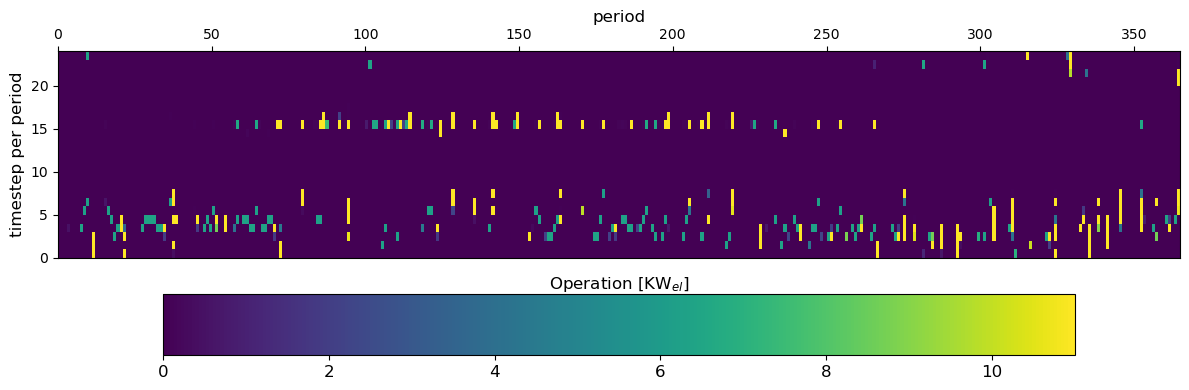

In [25]:
 fig, ax = fn.plotOperationColorMap(esM, "ev_charging", "H1")